In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import concurrent.futures as fut
from dotenv import load_dotenv  # hack for vs code jupyter extension
from pathlib import Path
import os
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PL.prediction.utils import get_season_name

pd.set_option('display.max_rows', 23)
pd.set_option('display.max_columns', None)
_ = load_dotenv("/mnt/HDD/Ivan/projects/FantasyPrediction/.envrc", override=True)
API_BASE_URL = "https://fantasy.premierleague.com/api/"

In [3]:
os.getcwd()

'/mnt/HDD/Ivan/projects/FantasyPrediction/PL'

In [4]:
from PL.Data.db import get_player_fpl_logs_df

player_logs_df = get_player_fpl_logs_df()
player_logs_df.sample(6)

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,squad_number,status,team,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text,expected_goals_per_90,saves_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,goals_conceded_per_90,now_cost_rank,now_cost_rank_type,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90,deadline_time,name,season_name
447,NaN,None,98747,0,0,0,0,0,1,4.5,None,0,Nick,0.0,424,False,,None,55,98747.jpg,4.2,Pope,12.6,False,None,a,15,4,157,0,0,0,0,0.0,28.5,Pope,3261,0,0,14,32,0,2,0,3,1,87,14,678,709.6,20.0,0.0,72.9,37,0.00,0.01,0.01,39.44,41,11,322,4,592,69,177,10,NaN,,NaN,,NaN,,0.00,2.4,0.00,0.00,1.09,0.88,87,1,471,69,34,7,33,6,1.02,0.39,2023-07-30 05:13:30.199700+00:00,Gameweek 1,2023/24
189,NaN,None,120202,0,0,0,0,0,4,0.3,None,0,Wout,0.0,183,False,,None,55,120202.jpg,1.4,Weghorst,0.6,False,None,a,6,90,24,0,0,0,0,0.0,4.4,Weghorst,790,0,1,4,11,0,0,0,1,0,0,0,56,97.6,183.7,144.0,42.4,10,2.02,1.16,3.18,14.60,302,31,161,18,185,34,257,32,NaN,,NaN,,NaN,,0.23,0.0,0.13,0.36,1.66,1.25,91,28,475,40,339,38,231,44,1.14,0.46,2023-07-30 05:13:30.199700+00:00,Gameweek 1,2023/24
471,NaN,None,173399,0,0,0,0,0,2,0.5,None,0,Mohamed,0.0,444,False,,None,40,173399.jpg,0.0,Dräger,0.2,False,None,a,16,17,0,0,0,0,0,0.0,0.0,Dräger,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,416,148,405,147,388,144,418,148,NaN,,NaN,,NaN,,0.00,0.0,0.00,0.00,0.00,0.00,550,162,42,17,423,149,390,149,0.00,0.00,2023-07-30 05:13:30.199700+00:00,Gameweek 1,2023/24
47,NaN,None,123354,0,0,0,0,0,2,0.5,None,0,Kortney,0.0,45,False,,None,40,123354.jpg,0.0,Hause,0.2,False,None,a,2,7,0,0,0,0,0,0.0,0.0,Hause,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,408,145,396,144,379,141,410,145,NaN,,NaN,,NaN,,0.00,0.0,0.00,0.00,0.00,0.00,541,159,33,14,415,146,354,129,0.00,0.00,2023-07-30 05:13:30.199700+00:00,Gameweek 1,2023/24
420,NaN,None,106760,0,0,0,0,0,2,3.1,None,0,Luke,0.0,398,False,,None,55,106760.jpg,4.0,Shaw,32.3,False,None,a,14,1,124,0,0,0,0,0.0,22.5,Shaw,2552,1,4,12,35,0,0,0,8,0,0,20,626,572.8,547.7,118.0,124.2,30,1.09,2.90,3.99,37.85,78,23,45,7,204,57,82,12,3.0,,4.0,,NaN,,0.04,0.0,0.10,0.14,1.33,1.23,89,7,473,194,49,7,7,3,1.06,0.42,2023-07-30 05:13:30.199700+00:00,Gameweek 1,2023/24
154,NaN,None,450434,0,0,0,0,0,4,2.3,None,0,Deniz,0.0,149,False,,None,55,450434.jpg,2.4,Undav,0.8,False,None,a,5,36,52,0,0,0,0,0.0,9.5,Undav,614,5,2,2,9,1,0,0,2,0,0,4,173,196.4,124.0,372.0,69.1,6,4.89,1.25,6.14,9.03,249,24,203,24,91,24,187,23,NaN,,NaN,,NaN,,0.72,0.0,0.18,0.90,1.32,1.32,140,36,524,48,212,23,192,36,0.88,0.29,2023-07-30 05:13:30.199700+00:00,Gameweek 1,2023/24


In [5]:
def get_szn_dir(season_start:int):
    return Path(os.environ['DATA_DIR']) / f"PL/data/{season_start}-{(season_start+1) % 100}"


def get_szn_fp(season_start:int):
    return get_szn_dir(season_start) / "players_raw.csv"
 

def _get_player_ser(season_year, first_name, second_name):
    players_raw_df = pd.read_csv(get_szn_fp(season_year))
    player_df = players_raw_df.query("(web_name == @second_name or second_name == @second_name) and first_name == @first_name")
    assert len(player_df) == 1, f"There are multiple results: {len(player_df)}"
    return player_df.squeeze()

def get_player_matches(season_year, first_name=None, second_name=None):
    assert first_name is not None or second_name is not None, "first and second name cannot be None"
    players_raw_df = pd.read_csv(get_szn_fp(season_year))
    query = ""
    if first_name is not None:
        query += "first_name == @first_name"
    if second_name is not None:
        if len(query) != 0:
            query += " and "
        query += "second_name == @second_name"
    return players_raw_df.query(query)

def get_player_game_logs(season_year, first_name, second_name):
    player_ser = _get_player_ser(season_year, first_name, second_name)
    player_id = player_ser.id
    szn_dir = Path(os.getcwd()) / f"Fantasy-Premier-League/data/{season_year}-{(season_year+1) % 100}"
    player_logs_fp = list(szn_dir.glob(f"players/*_{player_id}/gw.csv"))
    assert len(player_logs_fp) == 1 , f"player_logs_fp: {player_logs_fp}"
    player_logs_df = pd.read_csv(player_logs_fp[0])
    player_logs_df['player_name'] = player_ser.web_name
    return player_logs_df

def get_player_game_logs_by_id(season_year, player_name, player_id):
    szn_dir = get_szn_dir(season_year)
    player_logs_fp = list(szn_dir.glob(f"players/*_{player_id}/gw.csv"))
    assert len(player_logs_fp) == 1 , f"player_logs_fp: {player_logs_fp}"
    player_logs_df = pd.read_csv(player_logs_fp[0])
    player_logs_df['player_name'] = player_name
    return player_logs_df

def plot_player_logs_stats(player_df, cols_to_plot = ['total_points', 'minutes', 'goals_scored', 
        'bonus', 'assists', 'expected_assists', 'expected_goal_involvements', 'expected_goals', 'ict_index']):
    assert len(cols_to_plot) == 9
    fig, axs = plt.subplots(3,3, figsize=(15,12), sharex=True)
    sns.set_style('darkgrid')
    player_name = player_df['player_name'][0]
    for ax, col in zip([ax for ax_row in axs for ax in ax_row], cols_to_plot):
        sns.scatterplot(player_df.loc[:, col], ax=ax)
        sns.lineplot(player_df.loc[:, col].rolling(5, min_periods=1).mean(), ax=ax, color='grey', alpha=0.4)
        ax.title.set_text(f'{player_name} - {col}')

In [6]:
cleaned_players_df = pd.read_csv(get_szn_dir(2022) / "cleaned_players.csv")
display(cleaned_players_df.head())
players_raw_df = pd.read_csv(get_szn_dir(2022) / "players_raw.csv")
display(players_raw_df.head())

,first_name,second_name,goals_scored,assists,total_points,minutes,goals_conceded,creativity,influence,threat,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent,now_cost,element_type
0,Granit,Xhaka,7,8,153,2992,35,673.3,647.0,498.0,15,634,182.0,13,0,4,2.7,48,MID
1,Mohamed,Elneny,0,0,6,111,2,5.4,4.6,0.0,0,27,1.1,0,0,0,0.6,41,MID
2,Rob,Holding,1,0,21,562,13,10.3,152.0,54.0,0,120,21.6,0,0,0,0.2,42,DEF
3,Thomas,Partey,3,0,86,2480,28,439.6,513.2,240.0,6,468,119.5,11,0,5,0.4,47,MID
4,Martin,Ødegaard,15,8,212,3132,38,1100.4,960.0,920.0,30,813,298.3,13,0,4,33.3,69,MID


,assists,bonus,bps,chance_of_playing_next_round,chance_of_playing_this_round,clean_sheets,clean_sheets_per_90,code,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,creativity,creativity_rank,creativity_rank_type,direct_freekicks_order,direct_freekicks_text,dreamteam_count,element_type,ep_next,ep_this,event_points,expected_assists,expected_assists_per_90,expected_goal_involvements,expected_goal_involvements_per_90,expected_goals,expected_goals_conceded,expected_goals_conceded_per_90,expected_goals_per_90,first_name,form,form_rank,form_rank_type,goals_conceded,goals_conceded_per_90,goals_scored,ict_index,ict_index_rank,ict_index_rank_type,id,in_dreamteam,influence,influence_rank,influence_rank_type,minutes,news,news_added,now_cost,now_cost_rank,now_cost_rank_type,own_goals,penalties_missed,penalties_order,penalties_saved,penalties_text,photo,points_per_game,points_per_game_rank,points_per_game_rank_type,red_cards,saves,saves_per_90,second_name,selected_by_percent,selected_rank,selected_rank_type,special,squad_number,starts,starts_per_90,status,team,team_code,threat,threat_rank,threat_rank_type,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,yellow_cards
0,8,15,634,100.0,100.0,13,0.39,84450,NaN,NaN,0,0,-2,2,673.3,32,25,2.0,NaN,2,3,5.3,7.3,15,3.89,0.12,8.54,0.26,4.65,36.52,1.10,0.14,Granit,6.8,4,2,35,1.05,7,182.0,41,28,3,False,647.0,60,23,2992,NaN,2023-04-22T08:30:07.774962Z,48,265,157,0,0,NaN,0,NaN,84450.jpg,4.1,47,23,0,0,0.0,Xhaka,2.7,118,41,False,NaN,36,1.08,a,1,3,498.0,62,38,153,942505,0,832169,0,1.4,31.9,Xhaka,4
1,0,0,27,0.0,0.0,0,0.00,153256,NaN,NaN,0,0,-4,4,5.4,460,221,NaN,NaN,1,3,0.0,0.0,0,0.04,0.03,0.04,0.03,0.00,1.29,1.05,0.00,Mohamed,0.0,529,195,2,1.62,0,1.1,505,227,4,False,4.6,505,226,111,Knee injury - Unknown return date,2023-01-26T10:00:07.778526Z,41,634,335,0,0,NaN,0,NaN,153256.jpg,1.2,457,201,0,0,0.0,Elneny,0.6,249,81,False,NaN,1,0.81,i,1,3,0.0,593,233,6,202760,0,279536,0,0.0,1.5,Elneny,0
2,0,0,120,NaN,NaN,0,0.00,156074,NaN,NaN,0,0,-3,3,10.3,448,159,NaN,NaN,0,2,0.7,0.7,0,0.15,0.02,0.47,0.07,0.32,11.14,1.78,0.05,Rob,0.2,379,122,13,2.08,1,21.6,399,146,5,False,152.0,339,137,562,NaN,NaN,42,598,160,0,0,NaN,0,NaN,156074.jpg,1.5,405,144,0,0,0.0,Holding,0.2,377,143,False,NaN,6,0.96,a,1,3,54.0,341,118,21,23338,0,27980,0,0.0,5.0,Holding,0
3,0,6,468,100.0,100.0,11,0.40,167199,NaN,NaN,0,0,-3,3,439.6,70,59,NaN,NaN,0,3,1.5,1.9,3,2.17,0.08,4.76,0.17,2.59,32.27,1.17,0.09,Thomas,1.4,238,112,28,1.02,3,119.5,97,68,6,False,513.2,110,47,2480,NaN,2023-03-31T15:30:08.770925Z,47,311,186,0,0,NaN,0,NaN,167199.jpg,2.6,210,80,0,0,0.0,Partey,0.4,284,95,False,NaN,28,1.02,a,1,3,240.0,152,90,86,110171,0,141958,0,0.3,18.3,Partey,5
4,8,30,813,100.0,100.0,13,0.37,184029,3.0,NaN,0,0,4,-4,1100.4,7,5,1.0,NaN,5,3,7.7,6.9,3,8.02,0.23,17.77,0.51,9.75,37.94,1.09,0.28,Martin,6.4,8,4,38,1.09,15,298.3,6,4,7,True,960.0,10,3,3132,NaN,2023-03-09T22:30:08.763464Z,69,44,22,0,0,NaN,0,NaN,184029.jpg,5.7,7,3,0,0,0.0,Ødegaard,33.3,5,3,False,NaN,37,1.06,a,1,3,920.0,18,8,212,7014051,0,5015435,0,0.9,30.7,Ødegaard,4


In [7]:
display(cleaned_players_df.info())
display(players_raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778 entries, 0 to 777
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   first_name           778 non-null    object 
 1   second_name          778 non-null    object 
 2   goals_scored         778 non-null    int64  
 3   assists              778 non-null    int64  
 4   total_points         778 non-null    int64  
 5   minutes              778 non-null    int64  
 6   goals_conceded       778 non-null    int64  
 7   creativity           778 non-null    float64
 8   influence            778 non-null    float64
 9   threat               778 non-null    float64
 10  bonus                778 non-null    int64  
 11  bps                  778 non-null    int64  
 12  ict_index            778 non-null    float64
 13  clean_sheets         778 non-null    int64  
 14  red_cards            778 non-null    int64  
 15  yellow_cards         778 non-null    int

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778 entries, 0 to 777
Data columns (total 88 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   assists                               778 non-null    int64  
 1   bonus                                 778 non-null    int64  
 2   bps                                   778 non-null    int64  
 3   chance_of_playing_next_round          592 non-null    float64
 4   chance_of_playing_this_round          592 non-null    float64
 5   clean_sheets                          778 non-null    int64  
 6   clean_sheets_per_90                   778 non-null    float64
 7   code                                  778 non-null    int64  
 8   corners_and_indirect_freekicks_order  77 non-null     float64
 9   corners_and_indirect_freekicks_text   0 non-null      float64
 10  cost_change_event                     778 non-null    int64  
 11  cost_change_event_f

None

In [8]:
get_player_matches(2022, second_name="Álvarez").squeeze().id

319

Index(['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element',
       'expected_assists', 'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'starts', 'team_a_score', 'team_h_score',
       'threat', 'total_points', 'transfers_balance', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'player_name'],
      dtype='object')


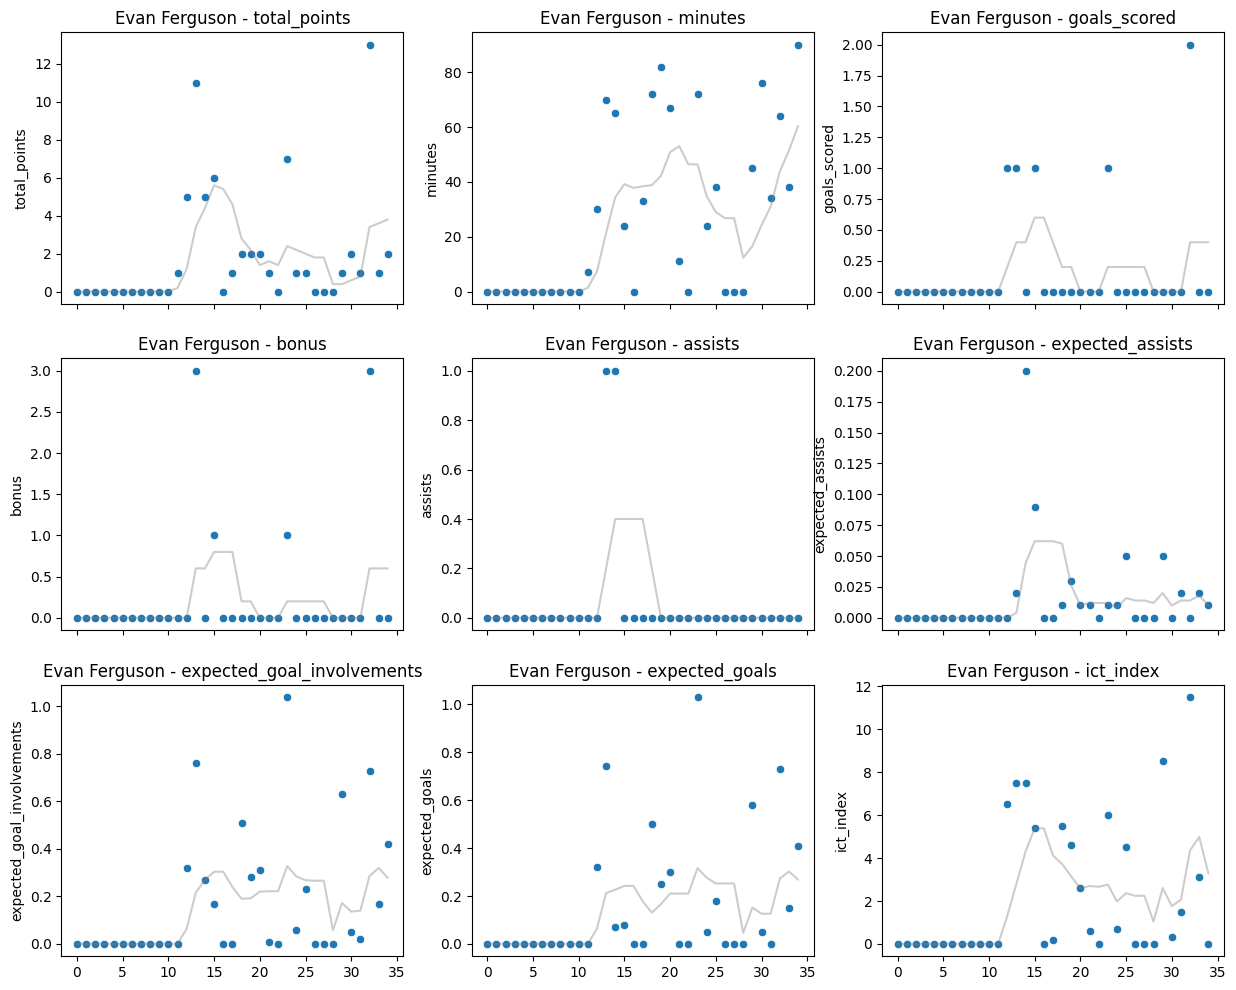

In [9]:
player_df = get_player_game_logs_by_id(2022, "Evan Ferguson", 596)
print(player_df.columns)
'''
['total_points', 'minutes', 'assists',
    'clean_sheets', 'goals_conceded', 'expected_goals_conceded', 
    'creativity', 'yellow_cards', 'ict_index']
'''
plot_player_logs_stats(player_df)

Index(['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element',
       'expected_assists', 'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'starts', 'team_a_score', 'team_h_score',
       'threat', 'total_points', 'transfers_balance', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'player_name'],
      dtype='object')


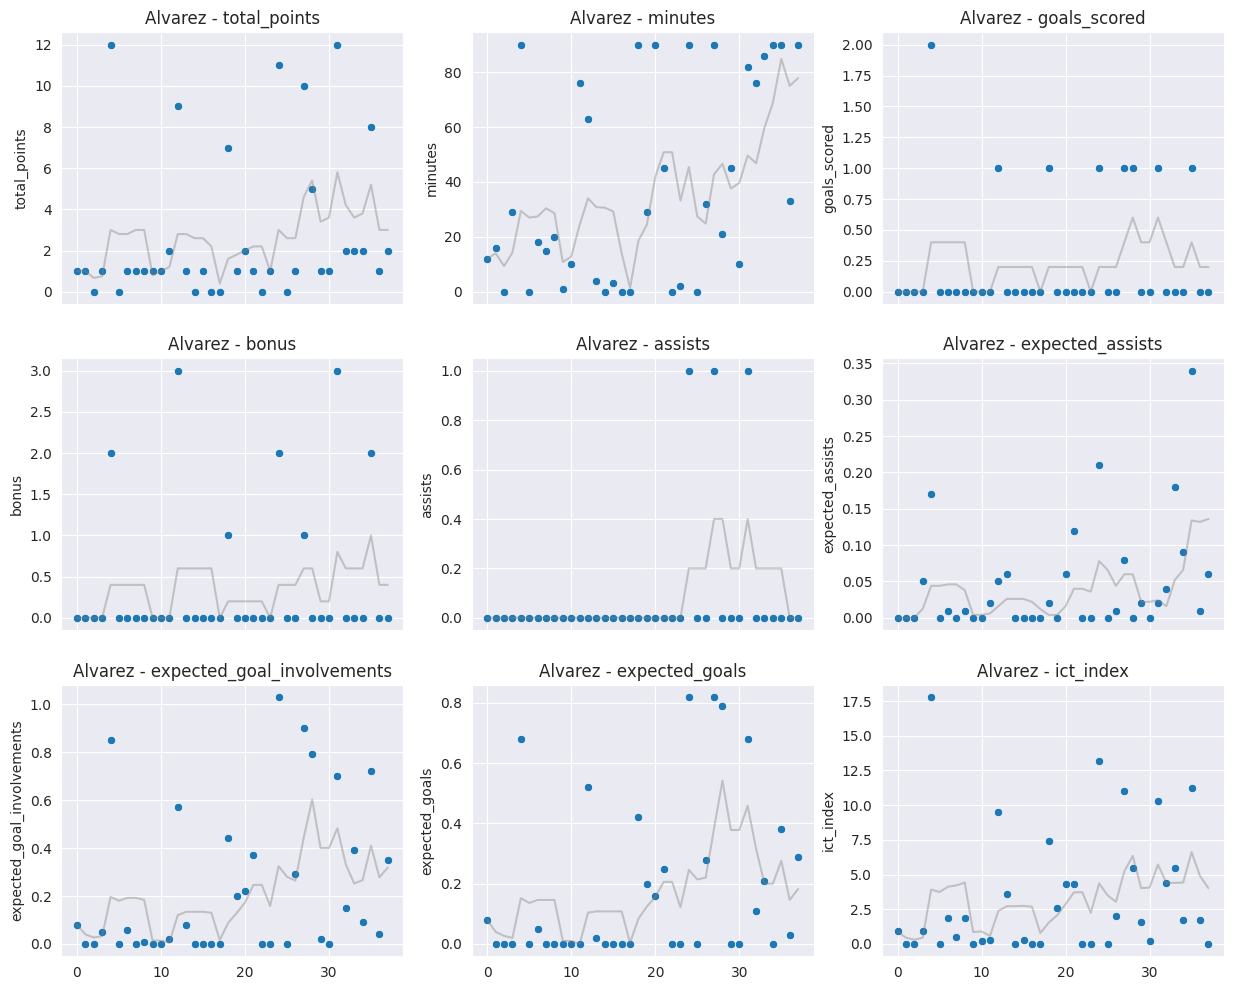

In [10]:
player_df = get_player_game_logs_by_id(2022, "Alvarez", 319)
print(player_df.columns)
'''
 ['total_points', 'minutes', 'assists',
    'clean_sheets', 'goals_conceded', 'expected_goals_conceded', 
    'creativity', 'yellow_cards', 'ict_index']
'''
plot_player_logs_stats(player_df)

In [11]:
def show_top_by_metric(interested_metric, season_list:list, top_k=10):
    def get_player_raw_details(season_start):
        df = pd.read_csv(get_szn_fp(season_start))
        df['season_year'] = get_season_name(season_start)
        return df
    
    df = pd.concat([get_player_raw_details(y) for y in season_list])
    display_cols = [interested_metric] + ["first_name", "second_name", "total_points", "minutes", "goals_scored", "id", "season_year"]
    return df.query("minutes > 1500").sort_values(interested_metric, ascending=False).loc[:, display_cols].iloc[:top_k]

In [12]:
show_top_by_metric('assists', [2022, 2021, 2020], 20)

,assists,first_name,second_name,total_points,minutes,goals_scored,id,season_year
474,18,Kevin,De Bruyne,183,2413,7,301,2022/23
681,17,Jarrod,Bowen,206,2987,12,420,2021/22
382,14,Mohamed,Salah,265,2758,23,233,2021/22
572,14,Harry,Kane,242,3083,23,388,2020/21
286,14,Jamie,Vardy,187,2838,15,224,2020/21
432,14,Bruno Miguel,Borges Fernandes,244,3101,18,302,2020/21
445,13,Mohamed,Salah,239,3290,19,283,2022/23
24,13,Leandro,Trossard,154,2237,8,111,2022/23
392,12,Kevin,De Bruyne,141,1995,6,272,2020/21
476,12,Riyad,Mahrez,126,1913,5,303,2022/23
